# Instance Segmentation with Mask R-CNN on Coffee Leaves

In this notebook, I want to dive deep into the Mask R-CNN model and explore how I was able to train it on a custom dataset to detect and segment coffee leaves. Since the dataset is new, collected from several coffee farms in Hawaii and Panama, it's important to understand the complexity of the task at hand and if Mask R-CNN is the right model for the job.

So what is the job exactly and why are we utilizing instance segmentation and not just object detection?

If the goal is to detect disease, pests, or other anomalies on coffee leaves, it's important to understand what those anomalies look like and where they are located. Looking into the BRACOL and RoCole dataset, many different defects can be found on coffee leaves, such as rust, miner, and more. These defects can be found in different shapes, sizes, and colors, and can be located anywhere on the leaf. Time and time again, classification models have successfully, and with high accuracy, detected these defects and have been able to classify them.

In the paper [Detection and Classification of Coffee Leaf Disease using Deep Learning](https://www.researchgate.net/publication/366126688_Detection_and_Classification_of_Coffee_Leaf_Disease_using_Deep_Learning) researchers classified coffee leaf diseases with an accuracy over 90%. Peering into the dataset, the images are taken in a controlled environment with a white background.

In another paper [Deep Learning for Image-Based Cassava Disease Detection](https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2017.01852/full) researchers classified disease with, again, greater than 90% accuracy. The images in this dataset are less controlled, containing a variety of backgrounds and lighting conditions. The authors even make a note: "The high accuracies reported suggest that variations in background had little effect on the prediction accuracies of the model" in regard to the different features present in the images as quoted: "Portions of images contained the sky, hands, shoes, and other vegetation, yet predictions in all image classes were greatly above the probability of randomly guessing (16.7%)."

However, depending on the task, there is a major disadvantage to using these datasets.

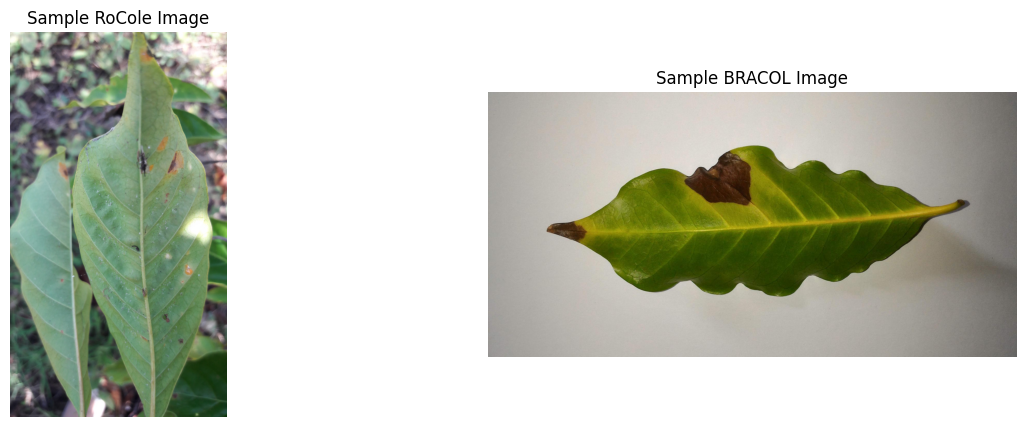

In [5]:
import cv2
import matplotlib.pyplot as plt

frame1 = cv2.imread('/home/jack/Mounts/DiskOne/kona_coffee/external/rocole_dataset/Photos/C10P36E2.jpg')
frame2 = cv2.imread('/home/jack/Mounts/DiskOne/kona_coffee/external/coffee-datasets/coffee-datasets/leaf/images/20.jpg')

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Sample RoCole Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Sample BRACOL Image')
plt.show()

The images in both these datasets contain only one, or a few, leaf instances in high resolution and clarity. In the BRACOL dataset, the images are taken in a controlled lighting environment, with the leaves placed on a white background. This makes for a very clean dataset, where features of disease can be easily detected and classified. Further, these datasets are good choices to introduce into a model in a transfer learning fashion in order to have more controlled ground truth. 

But, in the chaotic environment of a production coffee farm, controlled environments are not always possible (especially when collecting large datasets). From a farmers perspective, the easiest way to collect data is to take a picture of a leaf in the field and move on quickly. If they don't have to worry about the lighting conditions, if the image is focused, or if they only capture a single leaf per image, then they can collect data faster and more efficiently. From my own personal experience collecting the dataset, it does not take long to get fatigued from walking around a farm in the heat of the Hawaiian and Panamanian sun.

The last thing you want to worry about is the quality of the image you are taking. This is not a scientific statement but a practical one having spent my career around farmers and understanding their needs.

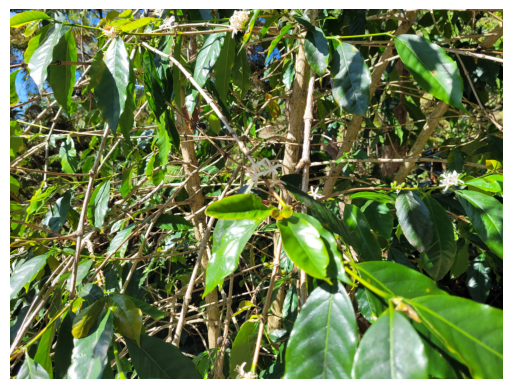

In [6]:
import cv2
import matplotlib.pyplot as plt

frame = cv2.imread('/home/jack/Mounts/CoffeeDataset/raw_images/kona_flowers_mixed/20240127_105348.jpg')

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

As an example, the image above is typical in the dataset I collected. The leaves are not always in focus, the lighting sometimes provides harsh contrasts, and there are, intentionally, multiple leaves in the image. But, with the effort of two individuals, we were able to collect thousands of images in many farms and in multiple countries in a short amount of time creating a wide variety of contextual backgrounds and leaf instances.

So, does this create a challenge for detecting disease on coffee leaves? Absolutely. The high contextual background (objects and backgrounds that are not disease or leaves) create a challenge for a model to accurately predict what is a "defect" and what is not. The harsh contrasting lighting conditions also make it difficult to know if disease is present or not. In my other research using a tile-based approach on a dataset of coffee leaves with similar based images, false positives were a major issue. The most common cause was the model detecting the background as a defect. Stems, shadows, and other background objects often have similar features to the disease we are trying to detect.

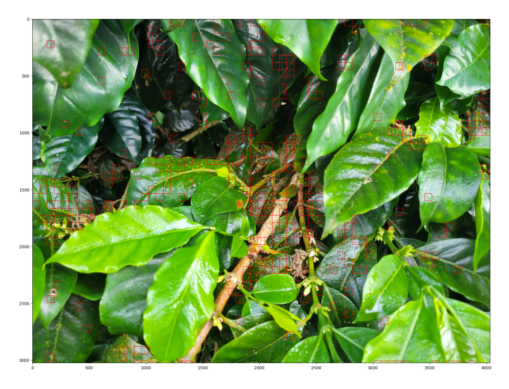

In [8]:
import requests
import numpy as np

response = requests.get('https://jackmead515.github.io/posts/kona_coffee_update_one_files/kona_coffee_update_one_21_0.png')

frame = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

As you can see in the image above, taken from a different modeling approach, the model detects many branches and flowers as defects.

It's easy to see that if we could segment the leaf from the background, then we could eliminate many of these false positives. This is where instance segmentation comes in. By segmenting the leaf from the background, we can then classify defects only present on the leaf and not the background.

For justification for this decision, we don't have to look far. In the paper [Coffee Disease Visualization and Classification](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8235481/), researchers utilizing Grad-CAM to visualize what a model was classifing as disease on coffee leaves. They found that by segmenting the leaf (with a UNet architecture) from the background, they could "guide" the model and improve it's ability to detect disease reducing false positives found in the background. Further, they utilized a tile-based approach to then classify if CLR (coffee leaf rust) was present which we have now proven to be a successful approach in our own research.

For my own research, I wanted to utilize a robust model that has been rigoursly tested with a strong community behind it. That's why I decided to use [Mask R-CNN](https://arxiv.org/abs/1703.06870), specifically using the [Detectron2](https://github.com/facebookresearch/detectron2) library. 

# Mask R-CNN

Mask R-CNN is actually just an extension of [Faster R-CNN](https://arxiv.org/abs/1506.01497), which is just an extension of [R-CNN](https://arxiv.org/abs/1311.2524). These models are flavors of object detection models that have been improved starting since 2013 when R-CNN was first introduced. R-CNN works using a sliding-window to perform object detection: the spatical localization of an object within an image defined by a bounding box and classified into a category. Faster-RCNN adds a faster method to propose regions of interest for object detection. But Mask R-CNN was introduced to add a third task to this process: instance segmentation. In addition to detecting objects and classifying them, Mask R-CNN also classifies each pixel as part of an object or not. Instance segmentation is explicitly different from semantic segmentation, which classifies each pixel into a category but does not differentiate between instances (bounding boxes of individual objects) of the same category (although this model can also be used for semantic segmentation).

Mask R-CNN contains many different customizable components allowing for further optimization and fine-tuning to the task at hand.

- The model extracts features from the image using a "backbone" network. This network can be any number of flavors: MobileNet, EfficientNet, ResNet, or even AlexNet.

- Then, it uses a Region Proposal Network (RPN) to generate candidate regions for objects. This is where the "Faster" part of Faster R-CNN comes in. The RPN is a fully connected network that scans the image and predicts regions that may contain an object. This is a major improvement over R-CNN, which used a sliding window approach to scan the image. The RPN utilizes a set of "anchors" which are boxes of different sizes and aspect ratios that are placed at different locations in the image. Predicting the probability of an object being in each anchor, the RPN can then learn to keep predicting better and better regions.

- The ROIAlign layer is then used to extract features from each region proposal. This layer uses the features from the backbone network, and the proposed regions to extract features that are then fed into the next part of the network.

- Next, in one half of the network, the model classifies the object and predicts a bounding box. This is the same as Faster R-CNN. in fact, this is the complete architecture of Faster R-CNN. The only difference is that Mask R-CNN adds another branch to the network.

- That other branch is the mask branch. This branch is a fully convolutional network that takes the features from the ROIAlign layer and predicts a mask for each object. Basically, it predicts a binary mask for each object in the image. Since this branch is independent of the object classification and bounding box prediction, it does not interfere with the other tasks and can be trained separately.

In the paper, the authors utilized a ResNet-50 backbone network and a Feature Pyramid Network (FPN) to improve the performance of the model. The FPN is a network that extracts features from different layers within the backbone. Since pooling layers usually reduce the size of the feature map, the FPN is able to extract this features before they are pooled. Most notably, the improvement comes in the detection of different sized objects.

While ResNet-50 is a very robust model, it may not always be the best choice. ResNet-101 with FPN is avaliable in Detectron2 as well. Currently, the Detectron2 library actually lacks support for MobileNet and EfficientNet backbones (smaller and faster architectures). However, in Pytorch there is an avaliable Mask R-CNN implementation and you can add different backends as I have done before: [MobileNetV3 with FPN in Pytorch](https://github.com/ainascan/maskrcnn_mobilenetv3_fpn)

For our dataset, I decided to use the ResNet-50 backbone with FPN. This was a decision based on convience and the fact that the model has been tested and proven to work well on a variety of tasks. Writting all the code for data loading, training, and evaluation, takes a significant amount of time and effort.

# Anchor Boxes

On the topic of Feature Pyramid Networks and Region Proposal Networks, it is important to understand these components as they are crucial to the performance of the model on a dataset. For our dataset, there contains many leaves of different sizes and shapes. We can visualize this by looking at the dataset.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import deltalake as dl
import boto3
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")

session = boto3.Session(profile_name='default')
credentials = session.get_credentials()
credentials = credentials.get_frozen_credentials()

os.environ['AWS_EC2_METADATA_DISABLED'] = 'true'

storage_options = {
    'AWS_REGION': 'us-west-1',
    'AWS_ACCESS_KEY_ID': credentials.access_key,
    'AWS_SECRET_ACCESS_KEY': credentials.secret_key,
    'AWS_S3_ALLOW_UNSAFE_RENAME': 'true'
}

annotations_df = dl.DeltaTable(
    table_uri='s3a://coffee-dataset/lake/raw_annotations',
    storage_options=storage_options
).to_pandas()

leaf_annotations = annotations_df[annotations_df['category_id'] == 'leaf']

leaf_annotations['bbox_width'] = leaf_annotations['bbox'].apply(lambda x: x[2])
leaf_annotations['bbox_height'] = leaf_annotations['bbox'].apply(lambda x: x[3])

leaf_annotations

,coco_file,width,height,category_id,bbox,segmentation,area,iscrowd,extras,image_name,image_path,bbox_width,bbox_height
0,coffee-dataset/datasets/coco_annotations/batch...,4032,3024,leaf,"[1962.4, 2569.2, 463.5, 278.9]","[2425.9, 2577.6, 2414.6, 2569.2, 2402.7, 2575....",58136.0,0,{},20240316_111616.jpg,coffee-dataset/raw_images/mountain_thunder_sho...,463.50,278.90
1,coffee-dataset/datasets/coco_annotations/batch...,4032,3024,leaf,"[2060.0, 0.0, 246.0, 606.6]","[2306.0, 0.0, 2176.0, 0.0, 2172.1, 5.7, 2168.0...",58334.0,0,{},20240316_111616.jpg,coffee-dataset/raw_images/mountain_thunder_sho...,246.00,606.60
2,coffee-dataset/datasets/coco_annotations/batch...,4032,3024,leaf,"[1772.9, 2013.0, 224.8, 446.6]","[1865.0, 2013.0, 1852.0, 2024.0, 1811.7, 2047....",70120.0,0,{},20240316_111616.jpg,coffee-dataset/raw_images/mountain_thunder_sho...,224.80,446.60
3,coffee-dataset/datasets/coco_annotations/batch...,4032,3024,leaf,"[2279.3, 2596.0, 250.7, 305.7]","[2522.0, 2608.0, 2497.0, 2596.0, 2464.0, 2599....",38673.0,0,{},20240316_111616.jpg,coffee-dataset/raw_images/mountain_thunder_sho...,250.70,305.70
4,coffee-dataset/datasets/coco_annotations/batch...,4032,3024,leaf,"[2384.0, 2566.0, 74.4, 177.8]","[2452.0, 2566.0, 2445.1, 2567.4, 2434.0, 2572....",6073.0,0,{},20240316_111616.jpg,coffee-dataset/raw_images/mountain_thunder_sho...,74.40,177.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13853,coffee-dataset/datasets/coco_annotations/origi...,4032,3024,leaf,"[840.79, 2274.52, 373.85, 749.48]","[950.14, 2274.52, 983.79, 2291.35, 1023.04, 23...",219797.0,0,{},20231203_102229.jpg,coffee-dataset/raw_images/mountain_thunder_mix...,373.85,749.48
13854,coffee-dataset/datasets/coco_annotations/origi...,4032,3024,leaf,"[3048.74, 1619.57, 610.39, 1208.76]","[3048.74, 1628.59, 3048.74, 1670.69, 3108.88, ...",277742.0,0,{},20231203_102229.jpg,coffee-dataset/raw_images/mountain_thunder_mix...,610.39,1208.76
13855,coffee-dataset/datasets/coco_annotations/origi...,4032,3024,leaf,"[1529.83, 1484.58, 243.61, 814.37]","[1708.01, 1561.88, 1716.02, 1510.69, 1702.1, 1...",98352.0,0,{},20231203_102229.jpg,coffee-dataset/raw_images/mountain_thunder_mix...,243.61,814.37
13856,coffee-dataset/datasets/coco_annotations/origi...,4032,3024,leaf,"[1692.5, 873.86, 1029.12, 1013.61]","[2688.67, 897.12, 2611.15, 873.86, 2496.8, 875...",470830.0,0,{},20231203_102229.jpg,coffee-dataset/raw_images/mountain_thunder_mix...,1029.12,1013.61


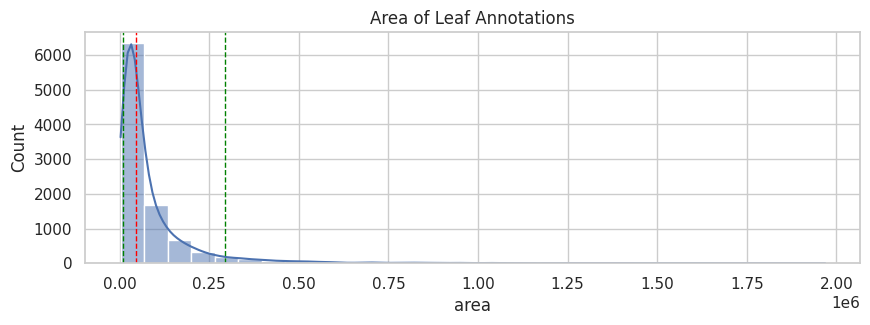

In [12]:
plt.figure(figsize=(10, 3))
sns.histplot(leaf_annotations['area'], bins=30, kde=True)
plt.axvline(leaf_annotations['area'].median(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(leaf_annotations['area'].quantile(0.05), color='green', linestyle='dashed', linewidth=1)
plt.axvline(leaf_annotations['area'].quantile(0.95), color='green', linestyle='dashed', linewidth=1)
plt.title(f'Area of Leaf Annotations')
plt.show()

<Figure size 800x800 with 0 Axes>

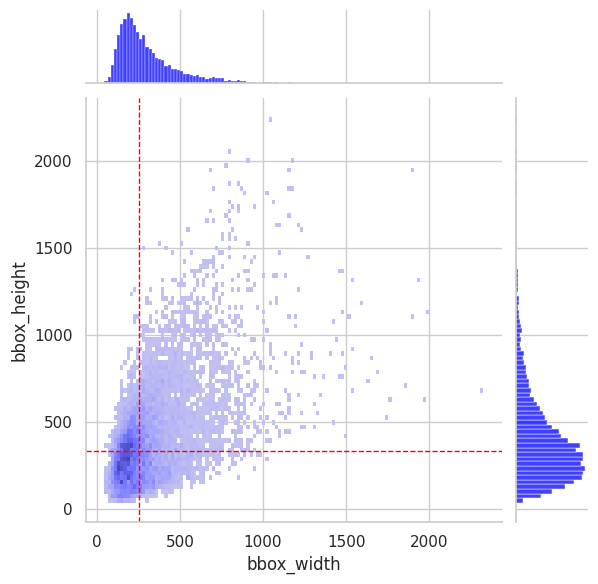

In [25]:
plt.figure(figsize=(8, 8))

sns.jointplot(x='bbox_width', y='bbox_height', data=leaf_annotations, color='blue', kind='hist')

median_width = leaf_annotations['bbox_width'].median()
plt.axvline(median_width, color='red', linestyle='dashed', linewidth=1)

median_height = leaf_annotations['bbox_height'].median()
plt.axhline(median_height, color='red', linestyle='dashed', linewidth=1)

plt.show()

Most of the leaves in the dataset are clustered together. But, there is a huge portion of the dataset outside that cluster. Leafs can vary from 100 pixels in width to 2000 pixels! In our first hyperparameter tuning task, the set of anchor sizes and ratios needs to be optimized to detect these different sized objects. The default set used in the paper is (32, 64, 128, 256, 512) with aspect ratios of 0.5, 1, 2. This set proved robust for the datasets it was trained on, but should be reviewed for optimization on our dataset.

So how should we tune these? A hyperparameter search would be too costly and expensive given our limited compute resources. Instead, we can actually look at the dataset we have and select a set of anchor sizes and rations that best fit the dataset. This is a common practice in object detection and can be done by looking at the distribution of object sizes in the dataset.

In this example [Anchor Boxes Generation using K-Means clustering](https://medium.com/@yerdaulet.zhumabay/generating-anchor-boxes-by-k-means-82f11c690b82) or here [Anchor-Boxes-with-KMeans](https://github.com/joydeepmedhi/Anchor-Boxes-with-KMeans), bounding boxes from the images are clustered into different groups with K-Means. Instead of using the L2 (Euclidean) distance as our metric, we can use the IOU of bounding boxes and the proposed anchor boxes. This is a simple and very efficient way to generate anchor boxes for this dataset.

A final note on this is that our anchor boxes could actually be of an infinite range of sizes and ratios depending on how we actually take the image. If we take the image at a different distance, the size of the leaf will change. If we take the image at a different angle, the shape of the leaf will change. For this dataset, I played the part of a farmer and took the images on a smartphone at a distance of 0.5 to 1 meter away from the tree. This seems to be the most practical distance a person would stand away, while still retaining quality. After all, the goal is to make it easy for a farmer to collect data.

# Data Annotation

Data annotation has made significant strides in the past few years. Incredible tools like [CVAT](https://github.com/cvat-ai/cvat) provide a completely open-sourced tool to annotating images. Pairing this with zero-shot detection models like [SAM](https://arxiv.org/abs/2304.02643) make it incredibly less time consuming to annotate objects. Using the latest tooling, I was able to annotate thousands of images in a short amount of time.

The dataset above, at the time of this publishing, is nearly 10,000 contours. This data was filtered and adjusted from a variety of sources. A few thousand are specifically filtered from the SAM model. But many tens of thousands of annotations are still left to be filtered through using this method!

In [28]:
sam_segged_df = dl.DeltaTable(
    table_uri='s3a://coffee-dataset/lake/raw_image_sam_segmentations_v2',
    storage_options=storage_options
).to_pandas(columns=['image_path'])

print(f'Total number of SAM segmentations: {sam_segged_df.shape[0]}')
print(f'Total number of unique images: {sam_segged_df["image_path"].nunique()}')

Total number of SAM segmentations: 150733
Total number of unique images: 2543


The pipeline I followed was:

- First, annotate every image we have captured with SAM. To fit on the GPU, I had to downscale the images and then resize the contours back to the original size. This causes some loss of information and makes the contours jagged on the edges. We can mitigate this by applying a [median blur](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9) to the contour and slightly [eroding](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gaeb1e0c1033e3f6b891a25d0511362aeb) it.

- Second, with the help of contractors, we annotated images using CVAT. Knowing what should be annotated and not was a difficult task. Some annotations are of various parts of leaves that may only be a small percentage of the total leaf area. Some are extremely unfocused or severly obfuscated by shadows or light. For guidance, I produced a presentation that showed examples of what should be annotated and what should not. Generally, at least 70% of the leaf should be visible, the leaf should be somewhat in focus, and the leaf should not be obstructed by other leaves or objects. This was a difficult task (specifically the most time consuming) and requires a lot of human judgement.

- Once all the annotations were filtered, they are combined into a final dataset for augmentation. A script was used to apply additive augmentation (that is, adding more images to the dataset). As you might imagine, the data augmentation techniques used adjusted the brightness, contract, rotation, jpeg compression, and sometimes even added noise like rain or fog. This was done to simulate the different conditions a farmer might take a picture in.

All of this data is compiled into a single COCO formatted dataset with a training, validation, and test set. Augmentations are applied to the training set only. The validation and test set are left as is.

The use of [DeltaLake](https://delta.io/) for data storage was also incredibly convenient for this task. It allowed me to switch to different machines if needed, and rollback changes in the version history in case I made a mistake. The dataset can also be documented with notes that are saved in the DeltaLake metadata. It's also extremely easy to scale in case large amounts of data need to be processed.

In [29]:
table = dl.DeltaTable(
    table_uri='s3a://coffee-dataset/lake/raw_image_sam_segmentations_v2',
    storage_options=storage_options
)
history = table.history(1)[0]
catalog_params = {key: value for key, value in history.items() if key.startswith('catalog_')}
catalog_params

{'catalog_description': 'Segmentations generated by SAM for raw images',
 'catalog_name': 'Raw Image SAM Segmentations'}

# Training

Finally, we have made it to the stage of training the model. Again, I utilized Detectron2 for this task. Tensorboard is integrated directly into the library, making it easy to monitor the training process. However, I found it more useful to add hooks in to monitor the training via [MLFlow](https://mlflow.org/). This platform allows for easy tracking of hyperparameters, metrics, and artifacts for multiple experiments. Standing this infrastructure up in Kubernetes, and connecting it to S3, I now have a robust system for tracking and versioning experiments and models. The artifacts are stored in S3 and can be easily downloaded and shared with others.

Even more, we can compare and contrast different experiments to see if model performance is improving or not. This is crucial for the hyperparameter tuning process.

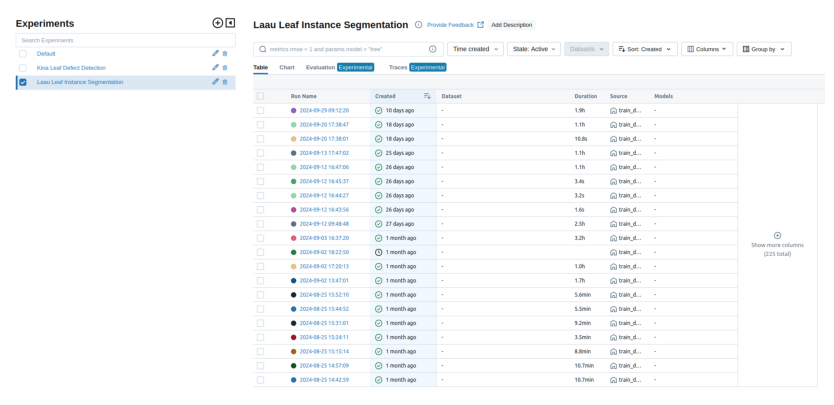

In [32]:
frame = cv2.imread('../images/mlflow.png')

plt.figure(figsize=(20, 5))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

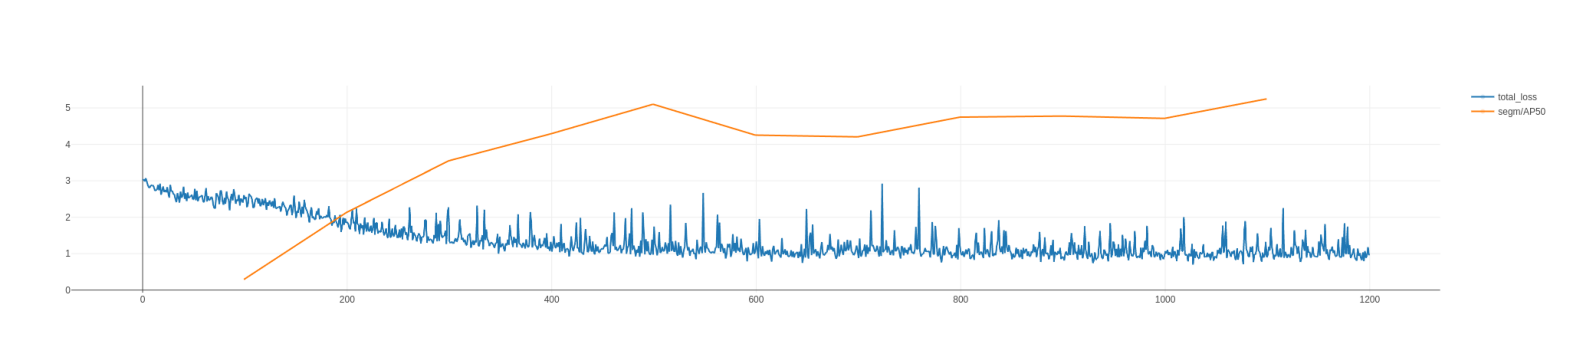

In [33]:
frame = cv2.imread('../images/laau_metrics_plot.png')

plt.figure(figsize=(20, 5))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

At the time of this writing, the image above shows the best trained model. Although only trained for 2000 epochs, this is because the validation mAP does not improve much after. And the overall loss has a difficult time crossing the 1.0 threshold.

But, the test mAP does reach nearly 0.25. This is a good start for the model and actually produces decent results on unseen data.

From here, I know improvements can be made. But we have a lot more data to annotate and filter through yet! A higher accuracy is surely yet to be achieved.

# Conclusion

In this notebook, I have outlined the task of instance segmentation of coffee leaves. While the task is complex, we have shown that Mask R-CNN is trainable on the dataset captured. Further tuning is certainly needed to improve the model's performance. Further annotation work is also needed to improve the quality of the dataset. Even after nearly 10,000 leaves, I still feel that there is much more diversity of leaves to be captured given not only the variety of environmental conditions, but plant species (this dataset is only Arabica), leaf ages, and of course leaf diseases.

I hope that this article was informative to the challenges of training a model on a brand new dataset. But also, how important it is to consider the user base of the product before data collection occurs.

# Citations

- He, Kaiming, et al. "Mask r-cnn." Proceedings of the IEEE international conference on computer vision. 2017.

- Yebasse, M., Shimelis, B., Warku, H., Ko, J., & Cheoi, K. J. (2021). Coffee Disease Visualization and Classification. Plants, 10(6), 1257. doi:10.3390/plants10061257 

- Paulos, Eyobed & Woldeyohannis, Michael. (2022). Detection and Classification of Coffee Leaf Disease using Deep Learning. 1-6. 10.1109/ICT4DA56482.2022.9971300. 

-  Ramcharan, A., Baranowski, K., McCloskey, P., Ahmed, B., Legg, J., & Hughes, D. P. (2017). Deep Learning for Image-Based Cassava Disease Detection. Frontiers in Plant Science, 8. doi:10.3389/fpls.2017.01852

-  Krohling, Renato A.; Esgario , Guilherme J. M.; Ventura, José A. (2019), “BRACOL - A Brazilian Arabica Coffee Leaf images dataset to identification and quantification of coffee diseases and pests”, Mendeley Data, V1, doi: 10.17632/yy2k5y8mxg.1

-  Parraga-Alava, Jorge; Cusme, Kevin; Loor, Angélica; Santander, Esneider (2019), “RoCoLe: A robusta coffee leaf images dataset ”, Mendeley Data, V2, doi: 10.17632/c5yvn32dzg.2